### Reproducing the results of Wheler and Kiladis 99

In [1]:
import warnings
import xarray as xr
from matplotlib import pyplot as plt
from pywk99.spectrum import get_power_spectrum, get_background_spectrum
from pywk99.spectrum import plot_spectrum, plot_spectrum_peaks
from pywk99.timeseries import remove_seasonal_cycle
from pywk99.timeseries import remove_linear_trend
from pywk99.waves import plot_dispersion_relations
from pywk99.filter import get_wave_filter_window, get_box_filter_window
from pywk99.filter import filter_variable, plot_filter_window

In [2]:
# run data/download.ipynb to download the example data
ds = xr.open_dataset("data/olr.2xdaily.1979-2022.nc")
variable = ds.olr.sel(time=slice("1979-01", "1996-08", None), lat=slice(15,-15, None))
variable = variable.sortby("lat")

In [3]:
warnings.filterwarnings("ignore", message="Converting non-nanosecond precision timedelta values to nanosecond precision")
variable_normalized = remove_linear_trend(variable)
variable_normalized = remove_seasonal_cycle(variable)

In [4]:
window_length = "92D"
overlap_length = "60D"
data_frequency = "12h"
symmetric_spectrum = get_power_spectrum(variable_normalized, "symmetric",
                                        data_frequency, window_length,
                                        overlap_length)
asymmetric_spectrum = get_power_spectrum(variable_normalized, "asymmetric",
                                         data_frequency, window_length,
                                         overlap_length)
background_spectrum = get_background_spectrum(symmetric_spectrum,
                                              asymmetric_spectrum)

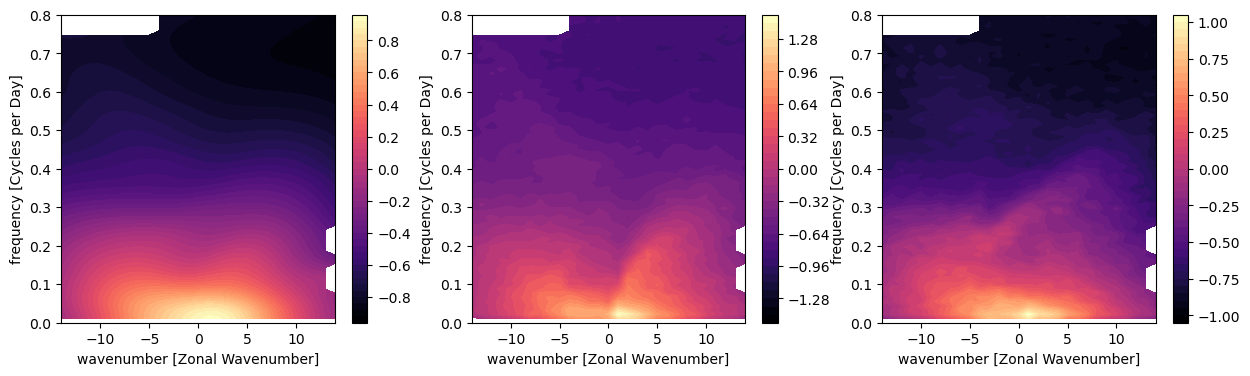

In [5]:
# Define regions with spectrum artifacts
flagged_window1 = get_box_filter_window(13.5, 14.5, 0.08, 0.15)
flagged_window2 = get_box_filter_window(13.5, 14.5, 0.18, 0.25)
flagged_window3 = get_box_filter_window(-14.5, -5, 0.75, 1)
flagged_windows = flagged_window1.union(flagged_window2).union(flagged_window3)
# plot spectrum
fig, (ax1, ax2, ax3) = plt.subplots(1 , 3, figsize=(15, 4))
plot_spectrum(background_spectrum, ax1, flagged_windows=flagged_windows)
plot_spectrum(symmetric_spectrum, ax2, flagged_windows=flagged_windows)
plot_spectrum(asymmetric_spectrum, ax3, flagged_windows=flagged_windows)

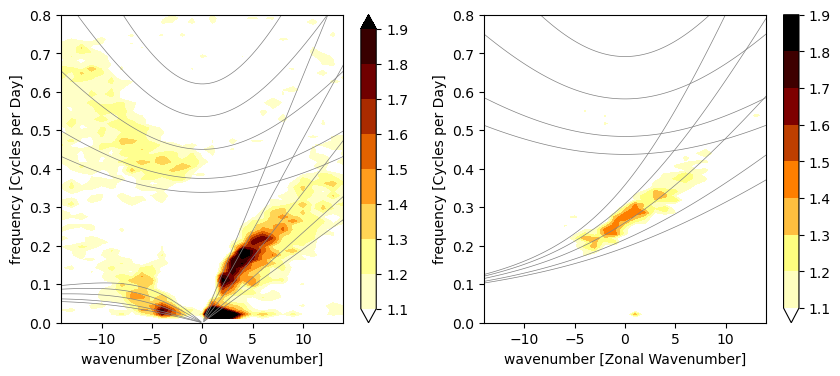

In [6]:
fig, (ax1, ax2) = plt.subplots(1 , 2, figsize=(10, 4))
plot_spectrum_peaks(symmetric_spectrum, background_spectrum, ax1, flagged_windows=flagged_windows)
plot_dispersion_relations("symmetric", ax1)
plot_spectrum_peaks(asymmetric_spectrum, background_spectrum, ax2, flagged_windows=flagged_windows)
plot_dispersion_relations("asymmetric", ax2)

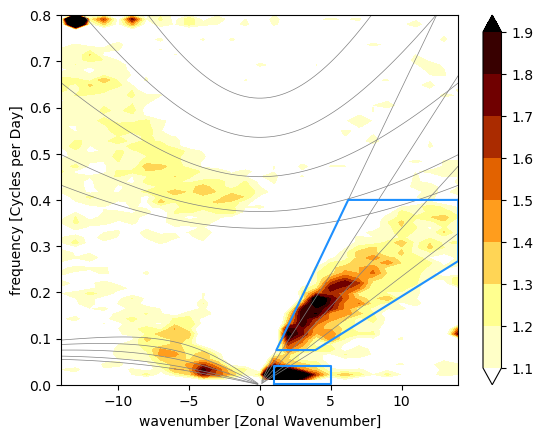

In [7]:
wave_type = "kelvin"
w_min, w_max = (0.075, 0.4)
k_min, k_max = (1, 14)
h_min, h_max = (8, 90)         #Equivalent depths
kelvin_wave_filter_window = get_wave_filter_window(wave_type,
                                                   k_min, k_max,
                                                   w_min, w_max,
                                                   h_min, h_max)
mjo_filter_window = get_box_filter_window(1, 5, 0.001, 0.04, name="mjo")
plot_spectrum_peaks(symmetric_spectrum, background_spectrum)
plot_dispersion_relations("symmetric")
plot_filter_window(kelvin_wave_filter_window)
plot_filter_window(mjo_filter_window)

In [8]:
filters = [mjo_filter_window, kelvin_wave_filter_window]
filtered_variable = filter_variable(variable, filters)

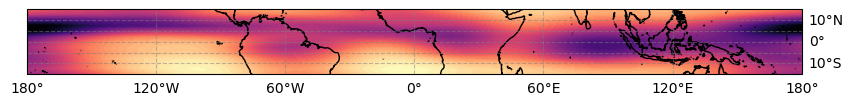

In [9]:
# plot the variance associated with the kelvin window
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()
gridlines = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                         color='gray', alpha=0.5, linestyle='--')
gridlines.top_labels = False
gridlines.left_labels = False
lon = filtered_variable.kelvin.lon.values
lat = filtered_variable.kelvin.lat.values
values = filtered_variable.kelvin.var("time").values.T
cyclic_data, cyclic_lons = add_cyclic_point(values, coord=lon)
cf = ax.contourf(cyclic_lons, lat, cyclic_data, 55, cmap="magma_r")

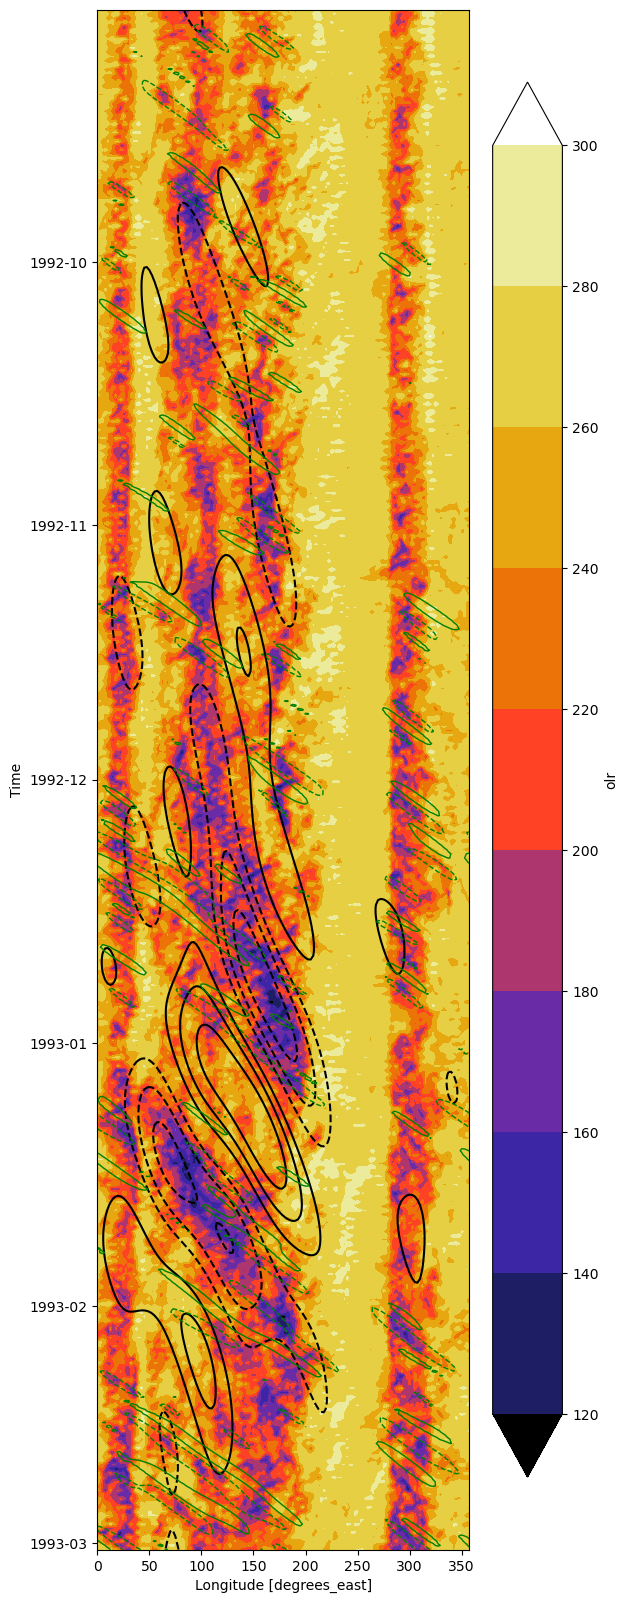

In [10]:
# plot the kelvin, mjo, and full fields
hovemoller = variable.sel(
    time=slice("1992-09-01", "1993-03-01"),
    lat=slice(-10, 2.5)
    ).mean("lat")
filtered_mjo_hovemoller = filtered_variable.mjo.sel(
    time=slice("1992-09-01", "1993-03-01"),
    lat=slice(-10, 2.5)
    ).mean("lat")
filtered_kelvin_hovemoller = filtered_variable.kelvin.sel(
    time=slice("1992-09-01", "1993-03-01"),
    lat=slice(-10, 2.5)
    ).mean("lat")
fig, ax = plt.subplots(1, 1, figsize=(6, 20))
hovemoller.plot.contourf(levels=10, cmap="CMRmap", ax=ax, vmin=120, vmax=300)
filtered_mjo_hovemoller.plot.contour(levels=[-30, -20, -10, 10, 20, 30],
                                     linestyles=["dashed"]*3 + ["solid"]*3,
                                     ax=ax,
                                     colors=["k"])
filtered_kelvin_hovemoller.plot.contour(levels=[-10, 10], ax=ax, colors=["green"], linewidths=1)
ax.invert_yaxis()